In [1]:
import itertools
import numpy as np
import math
from matplotlib import pyplot as plt
import random

# Monte Carlo Simulation Cathodoluminescence 
Following Meuret, Kociak, et. al., PRL & supplemental material. 


We outline the experimental and some material parameters taken from the literature which are allow our caculations to be realistic with respect to materials properties. 

#### Energy-scales
The electrons are accelerated with $60 keV$ potential. At this energy scale the electrons move at a veloctity $v = .44 * c$ 

1. Plasmon modes should be $\mathcal{O}(10 eV)$ excitations. This correlates well with the big EELS peak around 40 eV in Kociak's supplemental material. 
2. Electron-hole exicton pairs are of $E_{eh} = 5 eV$ as per the band-gap in diamond
3. NV$^0$ centers with $2.156 eV$ (575nm) energy gap between a doublet $^2E$ states and $^2A$ states. The NV gap isembedded within the semiconductor band-gap. 
4. There exist phonon bands with much lower energies than all the modes listed above. Photons exhibiting maximal bunching lie between 610-665 nm and this corresponds to a loss of $\sim .25eV$



In [2]:
ev_c2 = 1.783e-36   # eV/c^2 in units of kg
me_kg   = 9.1e-31   # mass of e- [kg]
me = me_kg/ev_c2    # mass of e- [eV/c^2]
c = 3e8             # speed of light [m/s]

v = np.sqrt(1-(510/(60+510))**2) # speed of e- w.r.t c i.e., gamma factor
print('(non)relativistic electron velocity(/c) is ' +str(v) + ' (' + str(np.sqrt(2*60/510)) + ')')      # v vs. non-relativistic calculation for velocity

h = 4.135e-15       # plank's constant [eV]  (not h-bar, just h)
l_NV = 575          # nv wavelength [nm]
f_NV = c*1e9/l_NV   # frequency (conversion nm <--> m)
E_NV = h * f_NV     # energy [eV]
E_660 = h * (c*1e9/660)
E_610 = h * (c*1e9/610)
DE = E_NV - E_660   # energy lost to plasmon [eV]
print('energy lost to plasmon around ' + str(DE) + ' eV')


q = 1.602e-19       # electron charge [C]
I0 = q/1e-9 * 1e9   # current for 1 e- per ns [nA]
print('current for 1e- per 1 nanosecond is ' + str(I0) + ' nA')


(non)relativistic electron velocity(/c) is 0.446593756539 (0.485071250073)
energy lost to plasmon around 0.27784584980237126 eV
current for 1e- per 1 nanosecond is 0.1602 nA


#### Timescales

The e-beam current depends on the extraction voltage which removes electrons.In the Kociak paper the currents range between $1pA$-$100pA$ while the ORNL experiment uses currents betwee $100 pA$ to $10 nA$. 

0. Bunching bandwidth of $\sim 100ns$ for 610 nm and 665 nm filtered data.
1. NV decay timescales seems to be on the order of $\mathcal{O}(10ns)$. 


#### Other physical constraints 

0. Following Kociak in the supplemental material section 6 the average plasmon creation number should be taken around ~2 
1. The interaction probability is defined as $P_{INT} \equiv 1 - \exp \left\{ - l_d \sigma \rho \right\}$]
   * The NV density is ~ 1200 NV color centers / nanocrystal. Since each nanocrystal is ~ $100 nm^3$ that comes to a rough density of $\rho = 1.2 *10^{-3} \frac{NV}{nm^3}$ or $\approx 1 \frac{NV}{(10nm)^3}$


## Time series simulation 
The time series simulation is performed in two different ways below 

1. We discretizing time into timesteps dt and at each either select an electron arrival or do not. 
   * Likewise, for NV's which are excited, they are allowed to probablistically decay at each timestep.. 
    
B. Following Kociak again, we stochastically pick electron arrivals times. 
   * These arrival time shall be the excitation times for the (possibly many) NV's which are stimulated within a very short (ps) time window. 
   * We also stochastically choose NV radiation times 


In [139]:
dt = 1                                  # time step in units of 10 [ps]
tm = 1e3 * dt                           # mean arrival time for em -- related to the current 
t_f = 1e4 * dt                          # simulation end time
t_em = np.linspace(0,t_f,int(t_f/dt))   # discretize time domain


# radiation statistical properties
tau_NV = 1e3 * dt                       # timescale for NV relaxation
p_rad = 1 - np.exp(-dt/tau_NV)          # emission probability at each timestep

# electron statistical properties
l_em = dt/tm                            # lambda parameter for poisson distribution of e- arrivals
p_em = l_em * np.exp(-l_em)             # probabilty of e- arrival & interaction within dt

# plasmon statistical properties
l_pl = 1                                # poissonian lambda for plasmon generation 
                                        # ==thickness/mean free path == avg plsmon number
n_pl_max = 150                          # max plasmons number cutoff
p_pl_pdf = [l_pl**n * np.exp(-l_pl)     # poisson pdf for plasmon generation
            / math.factorial(n) for n in range(n_pl_max)] 

# e-h exciton statistics
n_eh = 3                                 # number of e-h pairs excited per plasmon

# NV excitation statistics
# p_INT = 1 - np.exp(-1/2)               # probability to excite NV
p_INT = .1


# plasmon poissoinian cumulative distribution function
p_pl_cdf = [0] * n_pl_max             
for i in range(n_pl_max):   
    if i == 0:
            p_pl_cdf[0] = p_pl_pdf[0]
    else:
            p_pl_cdf[i] = p_pl_cdf[i-1] + p_pl_pdf[i]
            
def pick_npl(r, dist = p_pl_cdf):
    """
    draw plasmon number from 
    PARAMETERS
    ----------
    r: random number in [0,1]
    dist: cumulative distribution function sampled (p_pl_cdf by default)

    RETURNS
    -------
    # of plasmons excited
    """
    for p in dist:
        if r > p:
            pass
        else:
            return dist.index(p)
        
        
##### Numerical definitions of the autocorrelation function. 
##### taken from https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation

def autocorrelation (x) :
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal.
    """
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
#     return np.real(pi)[:int(x.size/2)]/np.sum(xp**2)   
    return np.real(pi)/np.sum(xp**2)     # modify to return whole autocorrelation

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]



# NV exponential decay properties

Find proper radiation probability given a mean lifetime/halflife for the NV relaxation events

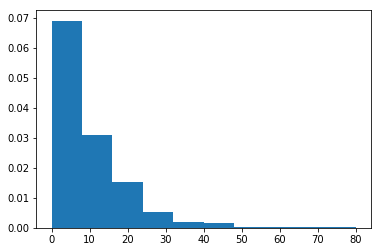

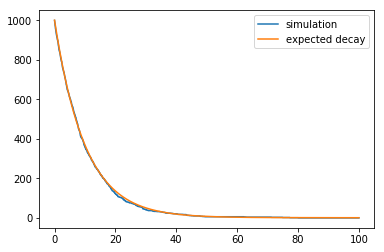

In [4]:
em_times = [0] * 1000
counter = [0] * len(t_em)
counter[0] = len(em_times)

for i,t in enumerate(t_em):
    
    if i > 0:
        counter[i] = counter[i-1]
    
    emissionss = 0
    for j in range(len(em_times)):
        if em_times[j]==0 and random.random() < p_rad:
            em_times[j] = t * 0.01
            emissionss += 1
     
    counter[i] = counter[i] - emissionss

nzn_times = [e for e in em_times if e != 0.0]
plt.hist(nzn_times, normed=True, bins=10)
plt.show()

decay_t = [len(em_times) * (np.exp(-t/tau_NV)) for t in t_em]
plt.plot(t_em * 0.01, counter, label = 'simulation')
plt.plot(t_em * 0.01, decay_t, label = 'expected decay')
plt.legend()
plt.show()


# Discretized time simulation
After setting all the stochastic parameters above we are ready to simulate our system. 
This is done in the code below. 

In [ ]:
NVs = [0] * len(t_em)                    # pre-allocate list for NVs excited at each timestep

em_arrivals = [0] * len(t_em)            # track arrival/excitations times for all modes
pl_arrivals = [0] * len(t_em)
nv_arrivals = [0] * len(t_em)

for i, t in enumerate(t_em):             # loop through discretized time domain    
    for l in range(i):                   # stocastically relax NVs excited at earlier times t_l < t_i
        if NVs[l] != 0:                  # exclude times w/ no excited NVs
            for m, n in enumerate(NVs[l]):
#                 print('Looking backwards to NVs excited at time ' + str(l))
                if random.random() < p_rad and n[1] == 0:
#                     print('Radiative event triggered at time ' + str(t_em[l]))
#                     print('index and excitation times ')
#                     print(m, n)
                    NVs[l][m][1] = t     # assign emission time 
    
    
    if  random.random() < p_em:                   # successful electron nano-crystal interaction 
        npl = pick_npl(random.random())           # number of plasmon modes populated according to p_pl_cdf
        
        NVs[i] = [[t,0] for j in range(npl)       # mark time of arrival 
                  for k in range(n_eh)            
                  if random.random() < p_INT]

        # track all exictations at each time-step
        em_arrivals[i] = 1                        # electrons
        pl_arrivals[i] = npl                      # plasmons

        if len(NVs[i]) == 0:
            NVs[i] = 0
            nv_arrivals[i] = 0
        else:
            nv_arrivals[i] = len(NVs[i])              # NVs
        
print('number of e- arrivals is ' + str(sum(em_arrivals)) + 
      '\n' + 'electron arrival frequency was found to be ' + 
      str(sum(em_arrivals)/len(t_em))  + ' vs the expected value of' + str(p_em))

In [ ]:
exicted_NVs = [n for n in NVs if n != [] and n != 0]
rad_times = [t[1] for times in exicted_NVs for t in times if t[1] != 0]
rad_times.sort()
rad_times_ns = [r * 0.01 for r in rad_times]           # rescaling of radiation times to [ns] units


tofe = [rad_times.count(t) for t in t_em]              # emissions per time

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(15,15))

ax[0].plot(t_em * 0.01, em_arrivals,'.',)
ax[1].plot(t_em * 0.01, pl_arrivals,'.')
ax[2].plot(t_em * 0.01, nv_arrivals, '.')
ax[3].plot(t_em * 0.01, tofe, '.')
ax[4].hist(rad_times_ns, normed=True, bins=50)


ax[0].set_ylabel('Electron interactions')
ax[1].set_ylabel('Plasmon exictations')
ax[2].set_ylabel('NV exictations')
ax[3].set_ylabel('Number of emissions')
ax[4].set_ylabel('Probability of radiation')
plt.show()

# print total: # timesteps, e- arrivals, plasmon excitations, nv_excitations
print("total time is " + str(len(t_em)) + "\n")
print(str(sum(em_arrivals)) + " electrons were excited \n")
print(str(sum(pl_arrivals)) + " plasmons were excited \n")
print(str(sum(nv_arrivals)) + " NV centers were excited \n")
print(str(sum(tofe)) + ' radiation events were detected')

## Calculate temporal autocorrelation, i.e. g2

Let us associate the above data labeled tofe, which is a time series data containing the number of emsissions per unit $dt$, with the cathodoluminescenc intensity $I(t)$, where t ranges from $t_0 = 0$ to the final time $t_f$ specified at the top of the code block.


The autocorrelation function is defined as $$ R(\tau) = \frac{E\left[(I_t - \mu)(I_{t+\tau} - \mu)\right]}{\sigma^2}. $$

Our data set has a finite length ($t_f/\delta t = t_f$) while the above equation is abstractly defined for an infinite time series.
We therefore calculate the autocorrelation over a range $2 * \tau_{MAX} = t_f$, i.e., from $-\tau_{MAX}$ to $\tau_{MAX}$.
To do so, we modify the definition of the autocorrelation function in a few ways: 
1. We define $I_{0}$ a slice of the total time series data which is centered at $t_f/2$ and of length $2 \tau_{MAX}$. Likewise, we also break up the time series data into a series of slices , of length $2 \tau_{MAX}$, which are centered about time $t_f/2 + \delta t * i$ for $i \in (-N_{MAX}, \cdots ,-1, 0, 1, \cdots, N_{MAX})$ where $N_{MAX} = t_f/(4 \delta t) \equiv \tau_{MAX}$
2. We take the convolution of each $I_i$ with $I_0$, 
$$ C_i = \sum_{j=1}^{2*N_{MAX}} \left[ I_i(j) I_0(j) \right]$$
3. We then divide this by the mean of each data set to get our g2: $$g^2(\tau) = \frac{C_{\tau}}{\mu_{\tau} \mu_0} $$


In [ ]:
tau_max = int(len(tofe)/4)
data0 = tofe[tau_max:3 * tau_max]
mu_2 = np.mean(data0)**2
def data(delay):
    """
    Time series day with integer delay
    """
    return tofe[0 + delay: 2 * tau_max + delay]

corr_data = [0] * 2 * tau_max
for i in range(2 * tau_max):
    di = data(i)
    corr_data[i] = sum(data0[j] * di[j] for j in range(2 * tau_max))/(2 * tau_max * np.mean(data0) * np.mean(di))

plt.plot(corr_data)
plt.show()


plt.plot(corr_data[tau_max-100:tau_max+100], '.') #zoom into zero delay signal window
plt.show()

corr_data.pop(tau_max)
plt.plot(corr_data, '.')
plt.show()

ac1 = autocorrelation(np.array(tofe))
plt.plot(ac1)
plt.show()

ac2 = autocorr(np.array(tofe))
plt.plot(ac2)
plt.show()



## Delay based histogram reconstruction of $g^2(\tau)$


In [ ]:
rad_tally = [rad_times_ns.count(c) for c in rad_times_ns]

# IMMEDIATE DELAYS ONLY 
# Kind of in the sytle of kociak. 
# 256 ps bin-sizes

delaytimes = [rad_times_ns[i+1] - rad_times_ns[i] for i in range(len(rad_times_ns)-1)]
plt.hist(delaytimes, bins=20)
plt.show()




delay_mat = [r1 - r2 for r1 in rad_times_ns for r2 in rad_times_ns]
# np.array(delay_mat).shape == (len(rad_times_ns)**2,)   # check shape
plt.hist(delay_mat, bins=20)
plt.show()

We now estimate the g2 correlation function by playing a little trick with the way that the time series emission data is interpreted. Namely, we go through the radiation events selecting a single reference event, let us say it is the $i$th event.
We imagine that this photon was detected by the first detector (click!) at time $t_i$. 
We now count the 'binned coincidences' by tagging other radiative emissions within a time window ($2 \tau_{MAX}$) centered about $t_i$, that is, $\tau^{(i)}_g = \left[ t_0 - \tau_{MAX} , \tau_0 +  \tau_{MAX} \right]$.




In [ ]:
TTM = 1e3 * 0.01     # 2 * \tau_MAX == total tau max [ns]
windowed_delay_times = []
for ti in rad_times_ns:
    if ti > TTM and ti < max(t_em * 0.01) - TTM: # make sure TTM time gap exists to left and right of t_i
        within_window = [r - ti for r in rad_times_ns if abs(r-ti) <= TTM] #and r != ti]
        windowed_delay_times.append(within_window)
        

merged_delays = list(itertools.chain.from_iterable(windowed_delay_times)) # flatten list of lists

plt.hist(merged_delays, bins=20)
plt.show()

In [ ]:
TTM = 1e3 * 0.01     # 2 * \tau_MAX == total tau max [ns]
windowed_delay_times = []
for ti in rad_times_ns:
    if ti > TTM and ti < max(t_em * 0.01) - TTM: # make sure TTM time gap exists to left and right of t_i
        within_window = [r - ti for r in rad_times_ns if abs(r-ti) <= TTM and r != ti]
        windowed_delay_times.append(within_window)
        

merged_delays = list(itertools.chain.from_iterable(windowed_delay_times)) # flatten list of lists

plt.hist(merged_delays, bins=20)
plt.show()

# Poissonian arrival and relaxation times

Redo the above simulation using poissonian sampled electron interarrival times, given a mean arrival time $t_m$, and poissonian distributed radiation times. 

1. We sample all the electron arrival times. This is performed by the emn_arrivals function. The sample times will be the times at which the NV's are excited. 


2. At each of these times plasmons, e-h excitions, and NVs are excited. Eventually the excited NV's radiate at some later time. The radiation times are output by the radiation times function

3. Finally we post-proccess the radiation times into a histogram style g2 correlation function

In [188]:
def em_arrrivals(mean_time, number = 1000):
    """
    Simulate the arrival times of e- particles
    according to a poission distribution given 
    
    Parameters
    ----------
    mean_time: the poissonian mean time (i.e. lambda parameter)
    number: the number of times to simulate
    
    Retruns
    -------
    delta_ts: list of interevent times
    times: 'discretized times' formed by summing delta_ts
    """
    delta_ts = [- tm *  np.log(1-random.random()) for i in range(number)]
    times = [0] * number

    for i,t in enumerate(delta_ts):
        if i == 0:
            times[i] = delta_ts[i]
        else:
            times[i] = times[i-1] + delta_ts[i]
    return delta_ts, times

def radiation_times(times, p_INT, t_r, neh = 3):
    """
    Simulate the radaition times of an unbounded collection of NV's
    
    Parameters
    ----------
    times: discretized times at which NV's may be excited
    p_INT: probability of an exciton to excite NV instead of dissipating 
    t_r: radiation timescale (half-life/relaxation time)
    neh: number of e-h excitons per plasmon
    npl: average number of plasmons excited per e-
    
    Returns
    -------
    rad_times: sorted list of times at which a radiation event occurs
    
    """
    number = len(times)
    nv_arrivals = [0] * number
  
    for k in range(number):                       # count number of NV excitations accompanying each electron    
        npl = pick_npl(random.random())           # number of plasmon modes populated according to p_pl_cdf
        for i in range(npl):
            for j in range(neh):
                if random.random() < p_INT:
                    nv_arrivals[k] += 1 
                
                
    rad_times = []                                 # simulate the radiation times series data
    for k in range(number):
        for j in range(nv_arrivals[k]):
            t_rad = - t_r * np.log(1-random.random())
            rad_times.append(times[k] + t_rad)

    rad_times.sort()
    
    return  rad_times



def delays(rad_times, tau_max):
    """
    Calculate delays 'between each photon and all the others' 
    within some time window. This way we may
    reconstruct the g2 correlation function
    in the "histogram mode" used to experimentally determine $g^{(2)}$. 
    The histogramming corresponds to the convolution of 
    two functions in some discrete time specificed by the bin width

    Parameters
    ----------
    rad_times: a list of ordered radiation times 
    tau_max: time window, e.g. of 100 ns, for duration of coincedence counting
    
    Returns:
    --------
    delay times: w/o self delay at \tau = 0.0
    """
    t_s = [t for t in rad_times if t > min(rad_times) + tau_max and t < max(rad_times) - tau_max ]

    delay_times = []
    for t1 in t_s:
        
        i = rad_times.index(t1)
        j = i + 1
        k = i - 1
        
        while abs(rad_times[j] - t1) < tau_max:
            delay_times.append(rad_times[j]-t1)
            j += 1

        while abs(rad_times[k] - t1) < tau_max:
            delay_times.append(rad_times[k]-t1)
            k -= 1
            
    return  delay_times

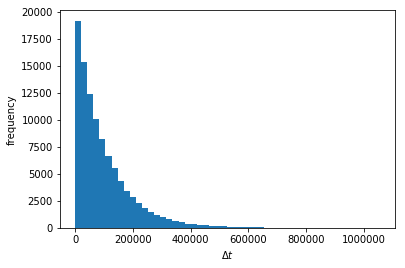

0.00150882402491 99875526.5635


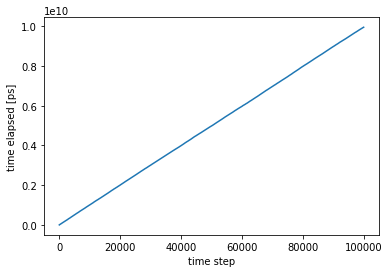

998.755265635 994.881165393 99875526.5635


In [165]:

# plot the poissonian time steps
plt.hist(dts, bins = 50)
plt.xlabel('$\Delta t$')
plt.ylabel('frequency')
plt.show()
print(min(delta_ts), max(times))

plt.plot(range(N),tms)
plt.xlabel('time step')
plt.ylabel('time elapsed [ps]')
plt.show()
# verify distribution with mean and standard deviation 
print(np.mean(delta_ts), np.sqrt(np.var(delta_ts)), max(times)) 

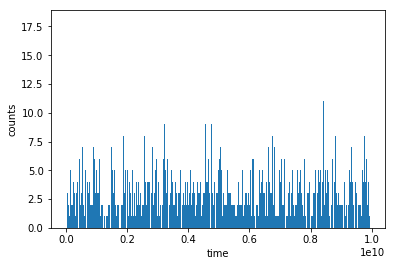

9849403709.1049957

In [170]:


# counts/time, i.e. the time series data
plt.hist(rts, bins=int(1e4))               
plt.xlabel('time')
plt.ylabel('counts')
plt.show()
min(rad_times), max(rad_times), dmax(rad_times) - max(times)

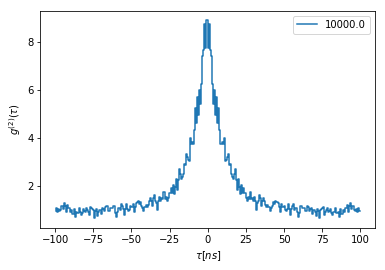

In [198]:


# Generate the histogram data directly
n_bins = 300
hist, bin_edges = np.histogram(delay_data, bins=n_bins)

# Get the cin centres rather than the edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.

# normalize hist counts
hist = hist/((np.mean(hist[int(3*n_bins/4):]) + np.mean(hist[:int(1*n_bins/4)]))/2)
# Plot
plt.step(bin_centers/1000, hist, label = str(1e4))
plt.xlabel('$\\tau [ns]$')
plt.ylabel('$g^{(2)}(\\tau)$')
plt.legend()
plt.show()


In [ ]:

tm = 1e5         # electron mean arrival time [ps]
N = int(1e5)     # number of electron events
t_r = 1e4        # NV radiation timescale [ps]    
p_INT = 0.1      # e-h/NV excitation probablilty
n_bins = 300     # histogram parameter

mean_times  = [1e3, 5e3, 1e4, 5e4, 1e5]
hists = [0] * len(mean_times)
bins  = [0] * len(mean_times)


times = [0] * len(mean_times)
r_tms = [0] * len(mean_times)
delayss = [0] * len(mean_times)
for i, tm in enumerate(mean_times):
    dts, times[i] = em_arrrivals(tm, N)
    r_tms[i] = radiation_times(times[i], p_INT, t_r, neh=3)
    delayss[i] = delays(r_tms[i], tau_max)

    hist, bin_edges = np.histogram(delayss[i], bins=n_bins)  # Generate the histogram data directly
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.      # Get the centres rather than the edges
    hists[i] = hist/((np.mean(hist[int(3*n_bins/4):]) +
                  np.mean(hist[:int(1*n_bins/4)]))/2)        # Normalize histogram counts
    bins[i] = bin_centers/1000                               # Plot with [ns] time units
    print(str(tm/1000) + ' is done')
    



In [ ]:
f, ax = plt.subplots(1, sharex=True)

for i in range(len(mean_times)):
    ax.step(bins[i], hists[i], label = str(mean_times[i]/1000))

# plt.xlabel('$\\tau [ns]$')
# plt.ylabel('$g^{(2)}(\\tau)$')
plt.legend()
plt.show()
